In [1]:
# Notebook influenced by this factorization machine post:
# yonigottesman.github.io/recsys/pytorch/elasticsearch/2020/02/18/fm-torch-to-recsys.html
# Changes include 1) LabelEncoder 2) refactored code 3) dataloaders + optimizer
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
# Data:     https://files.grouplens.org/datasets/movielens/ml-1m.zip
# Metadata: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt
DATA_DIR = './data/ml-1m/'
df_movies = pd.read_csv(DATA_DIR+'movies.dat', sep='::',
                        names=['movieId', 'title','genres'],
                        encoding='latin-1',
                        engine='python')
user_cols = ['userId', 'gender' ,'age', 'occupation', 'zipcode']
df_users = pd.read_csv(DATA_DIR+'users.dat', sep='::',
                       header=None,
                       names=user_cols,
                       engine='python')
df = pd.read_csv(DATA_DIR+'ratings.dat', sep='::',
                 names=['userId','movieId','rating','time'],
                 engine='python')
# Left merge removes movies with no rating. # of unique movies: 3883 -> 3706
df = df.merge(df_movies, on='movieId', how='left')
df = df.merge(df_users, on='userId', how='left')
df = df.sort_values(['userId', 'time'], ascending=[True, True]).reset_index(drop=True)
print(df.shape)
df.head(3)

(1000209, 10)


,userId,movieId,rating,time,title,genres,gender,age,occupation,zipcode
0,1,3186,4,978300019,"Girl, Interrupted (1999)",Drama,F,1,10,48067
1,1,1270,5,978300055,Back to the Future (1985),Comedy|Sci-Fi,F,1,10,48067
2,1,1721,4,978300055,Titanic (1997),Drama|Romance,F,1,10,48067


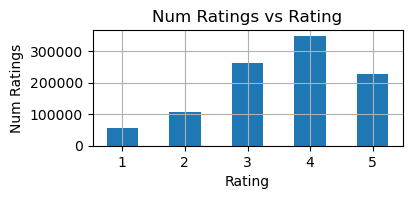

In [3]:
plt.figure(figsize=(4, 1.5))
bins = np.arange(1, 6, 0.5) - 0.25
plt.hist(df.rating.values, bins=bins)
plt.xticks(np.arange(1, 5.01, 1))
plt.title('Num Ratings vs Rating')
plt.xlabel('Rating')
plt.ylabel('Num Ratings')
plt.grid();

In [4]:
# Convert users and movies into categorical - use LabelEncoder
# Column categorical range remapped between [0, len(df.column.unique())-1]
# Remapping is important to reduce memory size of nn.Embeddings
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId', 'gender', 'age', 'occupation']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c+'_index'] = d[c].transform(df[c])
    print(f'# unique {c}: {len(d[c].classes_)}')

min_num_ratings = df.groupby(['userId'])['userId'].transform(len).min()
print(f'Min # of ratings per user: {min_num_ratings}')
print(f'Min/Max rating: {df.rating.min()} / {df.rating.max()}')
print(f'df.shape: {df.shape}')
df.head(3)

# unique userId: 6040
# unique movieId: 3706
# unique gender: 2
# unique age: 7
# unique occupation: 21
Min # of ratings per user: 20
Min/Max rating: 1 / 5
df.shape: (1000209, 15)


,userId,movieId,rating,time,title,genres,gender,age,occupation,zipcode,userId_index,movieId_index,gender_index,age_index,occupation_index
0,1,3186,4,978300019,"Girl, Interrupted (1999)",Drama,F,1,10,48067,0,2969,0,0,10
1,1,1270,5,978300055,Back to the Future (1985),Comedy|Sci-Fi,F,1,10,48067,0,1178,0,0,10
2,1,1721,4,978300055,Titanic (1997),Drama|Romance,F,1,10,48067,0,1574,0,0,10


In [5]:
# To use 1 embedding matrix, need to calculate & add offsets to each feature column
# Orig. paper uses 1-hot encoding, here we use ordinal encoding
# Ordinal encoding reduces memory size. Important for train speed
feature_cols = ['userId_index', 'movieId_index', 'gender_index', 'age_index',
                'occupation_index']
# Get offsets
feature_sizes = {}
for feat in feature_cols:
    feature_sizes[feat] = len(df[feat].unique())
feature_offsets = {}
NEXT_OFFSET = 0
for k,v in feature_sizes.items():
    feature_offsets[k] = NEXT_OFFSET
    NEXT_OFFSET += v

# Add offsets to each feature column
for col in feature_cols:
    df[col] = df[col].apply(lambda x: x + feature_offsets[col])
print('Offset - feature')
for k, os in feature_offsets.items():
    print(f'{os:<6} - {k}')
df.head(3)

Offset - feature
0      - userId_index
6040   - movieId_index
9746   - gender_index
9748   - age_index
9755   - occupation_index


,userId,movieId,rating,time,title,genres,gender,age,occupation,zipcode,userId_index,movieId_index,gender_index,age_index,occupation_index
0,1,3186,4,978300019,"Girl, Interrupted (1999)",Drama,F,1,10,48067,0,9009,9746,9748,9765
1,1,1270,5,978300055,Back to the Future (1985),Comedy|Sci-Fi,F,1,10,48067,0,7218,9746,9748,9765
2,1,1721,4,978300055,Titanic (1997),Drama|Romance,F,1,10,48067,0,7614,9746,9748,9765


In [6]:
# Make train and val dataset. Use last 5 rated movies per user
# 6040 unique users. Each user has minimum 20 rated movies
THRES = 5
cols = ['rating', *feature_cols]
df_train = df[cols].groupby('userId_index').head(-THRES).reset_index(drop=True)
df_val = df[cols].groupby('userId_index').tail(THRES).reset_index(drop=True)
print(f'df_train shape: {df_train.shape}')
print(f'df_val shape: {df_val.shape}')
df_train.head(3)

df_train shape: (970009, 6)
df_val shape: (30200, 6)


,rating,userId_index,movieId_index,gender_index,age_index,occupation_index
0,4,0,9009,9746,9748,9765
1,5,0,7218,9746,9748,9765
2,4,0,7614,9746,9748,9765


In [7]:
class MovieDataset(Dataset):
    """ Movie DS uses x_feats and y_feat """
    def __init__(self, df, x_feats, y_feat):
        super().__init__()
        self.df = df
        self.x_feats = df[x_feats].values
        self.y_rating = df[y_feat].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x_feats[idx], self.y_rating[idx]

In [8]:
BS = 1024
ds_train = MovieDataset(df_train, feature_cols, 'rating')
ds_val = MovieDataset(df_val, feature_cols, 'rating')
dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=2)

xb, yb = next(iter(dl_train))
print(xb.shape, yb.shape)
print(xb)
print(yb)

torch.Size([1024, 5]) torch.Size([1024])
tensor([[1284, 8863, 9747, 9751, 9759],
        [4578, 7796, 9746, 9749, 9759],
        [5545, 7292, 9747, 9749, 9769],
        ...,
        [3062, 7814, 9747, 9749, 9759],
        [4749, 8201, 9746, 9750, 9755],
        [  35, 7182, 9747, 9750, 9758]])
tensor([5, 4, 3,  ..., 5, 4, 4])


In [9]:
class FM(nn.Module):
    """ Factorization Machine + user/item bias, weight init., sigmoid_range 
        Paper - https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf
    """
    def __init__(self, num_feats, emb_dim, init, bias, sigmoid):
        super().__init__()
        self.x_emb = nn.Embedding(num_feats, emb_dim)
        self.bias = bias
        self.sigmoid = sigmoid
        if bias:
            self.x_bias = nn.Parameter(torch.zeros(num_feats))
            self.offset = nn.Parameter(torch.zeros(1))
        if init:
            self.x_emb.weight.data.uniform_(0., 0.05)

    def forward(self, X):
        # Derived time complexity - O(nk)
        x_emb = self.x_emb(X) # [bs, num_feats] -> [bs, num_feats, emb_dim]
        pow_of_sum = x_emb.sum(dim=1).pow(2) # -> [bs, num_feats]
        sum_of_pow = x_emb.pow(2).sum(dim=1) # -> [bs, num_feats]
        fm_out = (pow_of_sum - sum_of_pow).sum(1)*0.5  # -> [bs]
        if self.bias:
            x_biases = self.x_bias[X].sum(1) # -> [bs]
            fm_out +=  x_biases + self.offset # -> [bs]
        if self.sigmoid:
            return self.sigmoid_range(fm_out, low=0.5) # -> [bs]
        return fm_out

    def sigmoid_range(self, x, low=0, high=5.5):
        """ Sigmoid function with range (low, high) """
        return torch.sigmoid(x) * (high-low) + low

In [10]:
CFG = {
    'lr': 0.001,
    'num_epochs': 8,
    'weight_decay': 0.01,
    'sigmoid': True,
    'bias': True,
    'init': True,
}
n_feats = int(pd.concat([df_train, df_val]).max().max())
n_feats = n_feats + 1 # "+ 1" to account for 0 - indexing
mdl = FM(n_feats, emb_dim=100,
         init=CFG['init'], bias=CFG['bias'], sigmoid=CFG['sigmoid'])
mdl.to(device)
opt = optim.AdamW(mdl.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
loss_fn = nn.MSELoss()
print(f'Model weights: {list(dict(mdl.named_parameters()).keys())}')

Model weights: ['x_bias', 'offset', 'x_emb.weight']


In [11]:
epoch_train_losses, epoch_val_losses = [], []

for i in range(CFG['num_epochs']):
    train_losses, val_losses = [], []
    mdl.train()
    for xb,yb in dl_train:
        xb, yb = xb.to(device), yb.to(device, dtype=torch.float)
        preds = mdl(xb)
        loss = loss_fn(preds, yb)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    mdl.eval()
    for xb,yb in dl_val:
        xb, yb = xb.to(device), yb.to(device, dtype=torch.float)
        preds = mdl(xb)
        loss = loss_fn(preds, yb)
        val_losses.append(loss.item())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    s = (f'Epoch: {i}, Train Loss: {epoch_train_loss:0.2f}, '
         f'Val Loss: {epoch_val_loss:0.2f}'
        )
    print(s)

Epoch: 0, Train Loss: 0.88, Val Loss: 0.91
Epoch: 1, Train Loss: 0.81, Val Loss: 0.89
Epoch: 2, Train Loss: 0.76, Val Loss: 0.86
Epoch: 3, Train Loss: 0.72, Val Loss: 0.84
Epoch: 4, Train Loss: 0.67, Val Loss: 0.83
Epoch: 5, Train Loss: 0.62, Val Loss: 0.83
Epoch: 6, Train Loss: 0.57, Val Loss: 0.83
Epoch: 7, Train Loss: 0.51, Val Loss: 0.84


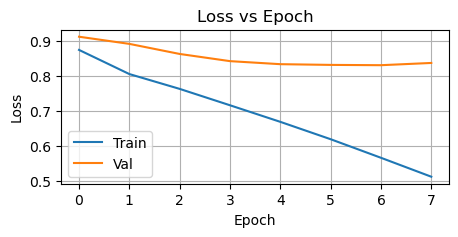

In [12]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();

Preds min/max: 0.65 / 5.45
Rating min/max: 1.00 / 5.00


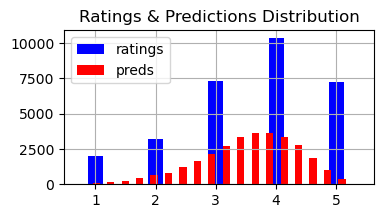

In [13]:
# Check predictions distribution
lpreds, lratings = [], []
mdl.eval()
for xb,yb in dl_val:
    xb, yb = xb.to(device), yb.to(device, dtype=torch.float)
    preds = mdl(xb)
    lpreds.extend(preds.detach().cpu().numpy().tolist())
    lratings.extend(yb.detach().cpu().numpy().tolist())

print(f'Preds min/max: {min(lpreds):0.2f} / {max(lpreds):0.2f}')
print(f'Rating min/max: {min(lratings):0.2f} / {max(lratings):0.2f}')
plt.figure(figsize=(4,2))
plt.hist(lratings, label='ratings', bins=(np.arange(1,7)-0.5),
         rwidth=0.25, color='blue')
plt.hist(lpreds, label='preds', bins=20, rwidth=0.5, color='red')
plt.title('Ratings & Predictions Distribution')
plt.grid()
plt.legend();

In [14]:
# Check TSNE for genres - Make dataframe of movie + embeddings + biases
movies = df.drop_duplicates('movieId_index').reset_index(drop=True)
movies['movieId'] = d['movieId'].transform(movies.movieId)
# Get movie embeddings and biases
idxs_movies = torch.tensor(movies['movieId_index'].values, device=device)
movie_embs = mdl.x_emb.weight[idxs_movies]
movie_biases = mdl.x_bias[idxs_movies]
movies['emb'] = movie_embs.tolist()
movies['bias'] = movie_biases.tolist()
movies.head(3)

,userId,movieId,rating,time,title,genres,gender,age,occupation,zipcode,userId_index,movieId_index,gender_index,age_index,occupation_index,emb,bias
0,1,2969,4,978300019,"Girl, Interrupted (1999)",Drama,F,1,10,48067,0,9009,9746,9748,9765,"[-0.09119528532028198, 0.06671150028705597, 0....",0.044621
1,1,1178,5,978300055,Back to the Future (1985),Comedy|Sci-Fi,F,1,10,48067,0,7218,9746,9748,9765,"[0.11205599457025528, 0.11180208623409271, 0.1...",0.228469
2,1,1574,4,978300055,Titanic (1997),Drama|Romance,F,1,10,48067,0,7614,9746,9748,9765,"[0.169271782040596, 0.09208009392023087, -0.15...",-0.016103


Genres: Children's|Horror|Documentary


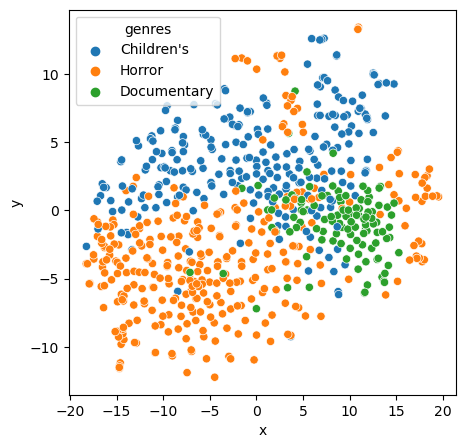

In [15]:
# Check TSNE, and scatter plot movie embeddings
# Movie embeddings do get separated after training
genre_cols = ['Children\'s', 'Horror', 'Documentary']
GENRES = '|'.join(genre_cols)
print(f'Genres: {GENRES}')

movies_subset = movies[movies['genres'].str.contains(GENRES)].copy()
X = np.stack(movies_subset['emb'].values)
ldr = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
Y = ldr.fit_transform(X)
movies_subset['x'] = Y[:, 0]
movies_subset['y'] = Y[:, 1]

def single_genre(genres):
    """ Filter movies for genre in genre_cols"""
    for genre in genre_cols:
        if genre in genres: return genre

movies_subset['genres'] = movies_subset['genres'].apply(single_genre)
plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x='x', y='y', hue='genres', data=movies_subset)

In [16]:
# Helper function/dictionaries to convert form name to labelEncoder index/label
d_name2le = dict(zip(df.title, df.movieId))
d_le2name = {v:k for k,v in d_name2le.items()}

def name2itemId(names):
    """Give movie name, returns labelEncoder label. This is before adding any offset"""
    if not isinstance(names, list):
        names = [names]
    return d['movieId'].transform([d_name2le[name] for name in names])

In [17]:
# Input: movie name. Output: movie recommendations using cosine similarity
IDX = name2itemId('Toy Story 2 (1999)')[0] # IDX = 2898, before offset
IDX = IDX + feature_offsets['movieId_index'] # IDX = 8938, after offset to get input movie emb
emb_toy2 = mdl.x_emb(torch.tensor(IDX, device=device))
cosine_sim = torch.tensor(
    [F.cosine_similarity(emb_toy2, emb, dim=0) for emb in movie_embs]
)
top8 = cosine_sim.argsort(descending=True)[:8]
movie_sims = cosine_sim[top8]
movie_recs = movies.iloc[top8.detach().numpy()]['title'].values
for rec, sim in zip(movie_recs, movie_sims):
    print(f'{sim.tolist():0.3f} - {rec}')

1.000 - Toy Story 2 (1999)
0.825 - Toy Story (1995)
0.626 - Bug's Life, A (1998)
0.617 - Aladdin (1992)
0.582 - Beauty and the Beast (1991)
0.541 - Iron Giant, The (1999)
0.519 - Chicken Run (2000)
0.515 - World of Apu, The (Apur Sansar) (1959)


In [18]:
# Factorization machines can handle cold start -> use metadata (age, gender)
# LabelEncoder.classes_ contains the map between integer and movielens metadata
# Metadata info: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt
feats = ['gender', 'age']
for feat in feats:
    print(feat)
    classes = d[feat].classes_
    for i,c in enumerate(classes):
        print(f'{i} : {c}')

gender
0 : F
1 : M
age
0 : 1
1 : 18
2 : 25
3 : 35
4 : 45
5 : 50
6 : 56


In [19]:
d_age_meta = {'Under 18': 1, '18-24': 18, '25-34': 25, '35-44': 35,
              '45-49': 45, '50-55': 50, '56+': 56
             }
d_gender = dict(zip(d['gender'].classes_, range(len(d['gender'].classes_))))
d_age = dict(zip(d['age'].classes_, range(len(d['age'].classes_))))
print(f'Gender mapping: {d_gender}')
print(f'Age mapping: {d_age}')

Gender mapping: {'F': 0, 'M': 1}
Age mapping: {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}


In [20]:
# Get cold start movie recs for a male (GENDER=1), ages 18-24 (AGE=1)
GENDER = 1
AGE = 1
gender_emb = mdl.x_emb(
    torch.tensor(GENDER+feature_offsets['gender_index'], device=device)
)
age_emb = mdl.x_emb(
    torch.tensor(AGE+feature_offsets['age_index'], device=device)
)
metadata_emb = gender_emb + age_emb
rankings = movie_biases + (metadata_emb*movie_embs).sum(1) # dot product
rankings = rankings.detach().cpu()
for i, movie in enumerate(movies.iloc[rankings.argsort(descending=True)]['title'].values[:8]):
    print(i, movie)

0 Shawshank Redemption, The (1994)
1 Usual Suspects, The (1995)
2 Life Is Beautiful (La Vita è bella) (1997)
3 Braveheart (1995)
4 Sanjuro (1962)
5 American Beauty (1999)
6 Matrix, The (1999)
7 Star Wars: Episode V - The Empire Strikes Back (1980)


In [21]:
# Save files for Streamlit app deployment - https://github.com/Datadote/movieyelp
SAVE = False
if SAVE:
    movie_embs_cpu = movie_embs.cpu()
    d_utils = {'label_encoder': d,
               'feature_offsets': feature_offsets,
               'movie_embs': movie_embs_cpu,
               'movies': movies,
               'd_name2le': d_name2le,
              }
    pd.to_pickle(d_utils, 'data/d_utils.pkl', protocol=4)
    mdl_scripted = torch.jit.script(mdl)
    mdl_scripted.save('mdls/fm_pt.pkl')